In [255]:
pip install mip

Note: you may need to restart the kernel to use updated packages.


In [256]:
import random as rd
import pandas as pd
import numpy as np
#from scipy.stats import norm
import matplotlib.pyplot as plt

# URLLC DRX possible configurations

deltaU = [2, 3, 4, 5, 6, 7, 8, 10, 14, 16, 20, 30, 32, 35, 40, 64, 80, 128, 160,
          256, 320, 512, 640]  # Set of Cycle Lenghts
fiU = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500,
       600, 800, 1000, 1200, 1600]  # Set of ON periods



omegaU = [25000, 30000, 40000, 50000]  #MHz
packetSizeU = [900, 1000, 1100, 1200]

# eMBB DRX possible configurations
deltaE = [10, 20, 32, 40, 60, 64, 70, 80, 128, 160, 256, 320, 512, 640, 1024, 1280,
          2048, 2560, 5120, 10240, 20480]
fiE = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500,
       600, 800]
gamaE = [0, 10, 20, 32, 40, 60, 64, 70, 80, 128, 160, 256, 320, 512, 640, 1024, 1280,
         2048, 2560, 5120, 10240]


omegaE = [5000, 10000, 15000, 20000, 25000, 30000]  #MHz
packetSizeE = [6000, 7000, 8000, 9000]

# Power Comsuption

Pmax = 10000
beta = []

In [257]:
def power(df):
  '''onLs = list(df['onTime [ms]'])
  powers = []
  for onL in onLs:
    powers.append(100*onL)'''
  df['Power'] = 100*df['onTime [ms]']
  Pit = list(df['Power'])
  return Pit

In [258]:
def adiciona(UEtype, dfUE, line):
  if UEtype == 1:
    linee = ["URLLC", 1, 1, 1, rd.choice(omegaU), 600, rd.randint(1, 2)]
    #soma += 50
    b = 0.4 + (0.6*(30/80))
    beta.append(b)

  elif UEtype == 2:
    linee = ["eMBB", 1, 1, 1, rd.choice(omegaE), 6516, rd.randint(1, 2)]

    #soma += 20
    b = 0.4
    beta.append(b)

  dfUE.loc[line] = linee
  return dfUE

In [259]:

def calculate_prbs_and_k(bwp):
    prbs_k_map = {
        5000: (25, 1),
        10000: (52, 2),
        15000: (79, 3),
        20000: (106, 4),
        25000: (133, 5),
        30000: (160, 6),
        40000: (216, 8),
        50000: (270, 10)
    }
    return prbs_k_map.get(bwp, (0, 1))

def calculate_signal(prbs, k):
    gains = np.random.rayleigh(scale=1, size=prbs // k)
    pBlocks = np.array(rd.choices(range(10, 30), weights=range(10, 30), k=prbs // k))
    return np.sum(gains * pBlocks)

def compute_snir(df1, df2):
    snir_list = np.array([])
    for row1 in df1.itertuples():
        bwp1 = row1[5]
        prbs, k = calculate_prbs_and_k(bwp1)
        signal1 = calculate_signal(prbs, k)

        interference = np.array([
            calculate_signal(prbs, k) for row2 in df2.itertuples()
            if row1[1] == row2[1] and bwp1 == row2[5]
        ])

        total_interference = np.sum(interference)
        snir = signal1 / (total_interference + 114)
        snir_list = np.append(snir_list, snir)

    return snir_list

def scheduler(df):
    df = df.sort_values(by='Cell_Site', ascending=True)
    df1 = df.query("Cell_Site == 1")
    df2 = df.query("Cell_Site == 2")

    snirUE1 = compute_snir(df1, df2)
    snirUE2 = compute_snir(df2, df1)

    df['SNIR'] = np.concatenate((snirUE1, snirUE2))
    return df

In [260]:
import math
def shannonCapacity(df):
  snirs = np.array(df['SNIR'])
  bwps = np.array(df['BWP [MHz]'])
  logaux = 1 + snirs
  log2 = np.log2(logaux)
  shannonCapacity = np.multiply(bwps, log2)
  shannonCapacity = shannonCapacity.tolist()
  df['Shannon_Capacity'] = shannonCapacity
  return df


In [261]:
def inicializaUE(nURLLC, nEMBB):
  dfUE = pd.DataFrame(columns=['Usuário', 'Cycle Length [ms]', 'onTime [ms]', 'offset [ms]', 'BWP [MHz]', 'Packet Size [bytes]', 'Cell_Site'])
  if nURLLC >= nEMBB:
    for i in range(0, (nURLLC + nEMBB)):
      if i < nEMBB:
        dfUE = adiciona(2, dfUE, i)
      else:
        dfUE = adiciona(1, dfUE, i)
  elif nURLLC < nEMBB:
    for i in range(0, (nURLLC + nEMBB)):
      if i < nURLLC:
        dfUE = adiciona(1, dfUE, i)
      else:
        dfUE = adiciona(2, dfUE, i)

  dfUE = scheduler(dfUE)
  dfUE = shannonCapacity(dfUE)
  return dfUE

In [262]:
def offsets_(UE):
  #Retorna o começo de cada offset

  cycle = UE[2]
  offsetsTimes = np.array([])
  qtdCycle = 100/cycle
  i = 0
  while i <= qtdCycle:
    offsetsTimes = np.append(offsetsTimes, cycle * i)
    i += 1
  #offsetsTimes = offsetsTimes.tolist()
  return offsetsTimes

In [263]:
def onTimes_(UE):
  # Retorna o começo de cada on

  offL = UE[4]
  cycle = UE[2]
  qtdCycle = 100/cycle
  onTimes = np.array([offL])
  i = 1
  while i <= qtdCycle:
    onTimes = np.append(onTimes, (cycle * i) + onTimes[0])
    i += 1
  return onTimes

In [264]:
def inTimes_(UE):
  # Retorna o começo de cada in

  onL = UE[3]
  cycle = UE[2]
  offL = UE[4]
  qtdCycle = 100/cycle
  in_ = np.array([(offL + onL + 1)])
  i = 1
  while i <= qtdCycle:
    in_ = np.append(in_, (cycle * i) + in_[0])
    i += 1

  return in_

In [265]:
def timeOff(UE, tcs):
  # Return the latency of an offset for each tc

  offs = offsets_(UE).astype(int)
  ons = onTimes_(UE).astype(int)
  taO = np.zeros(len(tcs))
  aux = []
  if offs[0] != ons[0]:
    i = 0
    for tc2 in tcs:
      for off, on in zip(offs, ons):
        if (off <= tc2 <= on):
          aux.append(on - tc2)
        else:
          aux.append(0)

      taO[i] = sum(aux)
      i += 1
      aux.clear()

  return taO

In [266]:
def timeIn(tcs, UE):
  # Return the latency of an in time for each tc

  cycle = UE[2] # Access column value using iloc
  onL = UE[3]
  offL = UE[4]
  offs = offsets_(UE).astype(int)
  #ons = onTimes_(UE).astype(int)
  ins = inTimes_(UE).astype(int)
  aux = []
  taI = np.zeros(len(tcs))
  if cycle != onL:
    i = 0
    for tc2 in tcs:
      for inn, off in zip(ins, offs):
        if (inn <= tc2 <= (off + cycle + 1)):
            aux.append(offL + (off + cycle + 1 - tc2))
        else:
          aux.append(0)

      taI[i] = sum(aux)
      i += 1
      aux.clear()

  return taI

In [267]:
from scipy.stats import poisson
def arrivalTimePoisson():
  tcs = np.linspace(0, 100, 1000)
  return tcs

In [268]:
def latencyCycle(tc, dfUE):
  # Return the latency cycle for each UE
  lc = []
  for UE in dfUE.itertuples():
    taI = timeIn(tc, UE)
    taO = timeOff(UE, tc)
    latencyCycle = taI + taO
    lc.append(latencyCycle.tolist())
  dfUE['Latency_Cycle'] = lc
  #return dfUE

In [269]:

def calculate_kmax(bwp, user_type):
    kmax_map = {
        'URLLC': {25000: 5, 30000: 6, 40000: 8, 50000: 10},
        'eMBB': {
            25000: 5, 30000: 6, 20000: 4, 5000: 1,
            10000: 2, 15000: 3, 40000: 8, 50000: 10
        }
    }
    return kmax_map[user_type].get(bwp, 1)

def assign_dci_times(kmax_arr, on_time_arr, cycle_length_arr, columns):
    aux = np.zeros((len(kmax_arr), columns), dtype=int)

    for column in range(columns):
        aux_list = []

        for i, kmax in enumerate(kmax_arr):
            if i not in aux_list:
                indexes = np.where(kmax_arr == kmax)[0].tolist()
                aux_list.extend(indexes)

                k, group = 0, 0
                #qtd_group = on_time_arr[i] // kmax
                qtd_group = len(indexes) // kmax

                for ue in indexes:
                    if k % kmax == 0 and k != 0:
                        group += 1
                    if group >= qtd_group and group % qtd_group == 0:
                        k = 0

                    if group < qtd_group:
                        aux[ue][column] = group
                    elif group < qtd_group * 2:
                        aux[ue][column] = group + cycle_length_arr[ue]
                    else:
                        aux[ue][column] = group + 2 * cycle_length_arr[ue]

                    k += 1

    return aux

def DCI(df):
    # Separar os dataframes por tipo de usuário
    df1 = df.query("Usuário == 'URLLC'")
    df2 = df.query("Usuário == 'eMBB'")

    # Preparar arrays de kmax, onTime, e Cycle Length
    kmax1 = np.array([calculate_kmax(bwp, 'URLLC') for bwp in df1['BWP [MHz]']])
    kmax2 = np.array([calculate_kmax(bwp, 'eMBB') for bwp in df2['BWP [MHz]']])

    # Atribuir tempos de DCI
    aux1 = assign_dci_times(kmax1, np.array(df1['onTime [ms]']), np.array(df1['Cycle Length [ms]']), len(df1['Latency_Cycle'].iloc[0]))
    aux2 = assign_dci_times(kmax2, np.array(df2['onTime [ms]']), np.array(df2['Cycle Length [ms]']), len(df2['Latency_Cycle'].iloc[0]))

    # Adicionar colunas de tempo de DCI
    df1['DCI_time'] = aux1.tolist()
    df2['DCI_time'] = aux2.tolist()

    # Concatenar e retornar o dataframe original com a coluna DCI_time
    df_combined = pd.concat([df1, df2], ignore_index=True)
    df['DCI_time'] = df_combined['DCI_time']
    # return df

In [270]:
def transmissionTime(df, tcs):
  sizes = np.array(df['Packet Size [bytes]'])
  capacities = np.array(df['Shannon_Capacity'])
  tT = []

  for size, capacity in zip(sizes, capacities):
    aux = []
    for i in range(np.size(tcs)):
      aux.append(size/capacity)  
    tT.append(aux)

  df['Transmission_time'] = tT

  #return df

In [271]:
def totalLatency1(df):
  latencyCycle = np.array(df['Latency_Cycle'])
  tT = np.array(df['Transmission_time'])
  dci = np.array(df['DCI_time'])

  totalLatencyaux = latencyCycle + dci
  totalLatency = totalLatencyaux + tT
  df['Total_Latency'] = totalLatency
  #return df

In [272]:
from mip import Model, xsum, MINIMIZE, BINARY
import numpy as np
import pandas as pd

# Inicializar os DataFrames de usuários
dfUEs = [inicializaUE(2, 8), inicializaUE(3, 7), inicializaUE(4, 6), inicializaUE(5, 5), inicializaUE(6, 4), inicializaUE(7, 3)]
tc = arrivalTimePoisson()
for df in dfUEs:
    transmissionTime(df, tc)

# Definir valores possíveis para as variáveis
valores_x = [2, 3, 4, 5, 6, 7, 8, 10, 14, 16, 20, 30, 32, 35, 40, 64, 80, 128, 160, 256, 320, 512, 640]
valores_y = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 800, 1000, 1200, 1600]
valores_z = [10, 20, 32, 40, 60, 64, 70, 80, 128, 160, 256, 320, 512, 640, 1024, 1280, 2048, 2560, 5120, 10240, 20480]
valores_w = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 800]
valores_h = [0, 10, 20, 32, 40, 60, 64, 70, 80, 128, 160, 256, 320, 512, 640, 1024, 1280, 2048, 2560, 5120, 10240]

# Função para calcular a latência total para usuários URLLC
def totalLatency(df, x, y):
    latencias = xsum((x[i] - y[i]) for i in range(len(x)))  # Alteração aqui para x - y
    return latencias

# Função para otimizar URLLC e eMBB com prioridade para capacidade de Shannon
def optimize_for_all_users(df):
    # Criar o modelo com objetivo de minimizar
    model = Model(sense=MINIMIZE)

    # Obter os índices dos usuários URLLC e eMBB
    urllc_indices = df.query("Usuário == 'URLLC'").index
    embb_indices = df.query("Usuário == 'eMBB'").index

    # Criar variáveis binárias para escolher exatamente um valor de x e y para cada usuário URLLC
    bin_x = [[model.add_var(var_type=BINARY) for _ in range(len(valores_x))] for _ in urllc_indices]
    bin_y = [[model.add_var(var_type=BINARY) for _ in range(len(valores_y))] for _ in urllc_indices]

    # Criar variáveis binárias para escolher exatamente um valor de z, w e h para cada usuário eMBB
    bin_z = [[model.add_var(var_type=BINARY) for _ in range(len(valores_z))] for _ in embb_indices]
    bin_w = [[model.add_var(var_type=BINARY) for _ in range(len(valores_w))] for _ in embb_indices]
    bin_h = [[model.add_var(var_type=BINARY) for _ in range(len(valores_h))] for _ in embb_indices]

    # Garantir que apenas um valor seja selecionado para cada variável de cada usuário
    for i in range(len(bin_x)):
        model += xsum(bin_x[i]) == 1  # Apenas um valor de x por usuário URLLC
        model += xsum(bin_y[i]) == 1  # Apenas um valor de y por usuário URLLC
    for i in range(len(bin_z)):
        model += xsum(bin_z[i]) == 1  # Apenas um valor de z por usuário eMBB
        model += xsum(bin_w[i]) == 1  # Apenas um valor de w por usuário eMBB
        model += xsum(bin_h[i]) == 1  # Apenas um valor de h por usuário eMBB

    # Definir as variáveis x, y, z, w e h como os valores selecionados diretamente dos vetores
    x = [xsum(bin_x[i][j] * valores_x[j] for j in range(len(bin_x[i]))) for i in range(len(bin_x))]
    y = [xsum(bin_y[i][j] * valores_y[j] for j in range(len(bin_y[i]))) for i in range(len(bin_y))]
    z = [xsum(bin_z[i][j] * valores_z[j] for j in range(len(bin_z[i]))) for i in range(len(bin_z))]
    w = [xsum(bin_w[i][j] * valores_w[j] for j in range(len(bin_w[i]))) for i in range(len(bin_w))]
    h = [xsum(bin_h[i][j] * valores_h[j] for j in range(len(bin_h[i]))) for i in range(len(bin_h))]

    # Adicionar restrições
    for i in range(len(urllc_indices)):
        model += y[i] + 0.5 * y[i] <= x[i]  # Restrição y + 0.5 * y <= x

    for i in range(len(embb_indices)):
        model += w[i] + h[i] <= z[i]  # Restrição w + h <= z

    # Penalizar os usuários URLLC e eMBB de forma diferente para induzir variações
    total_power = xsum(1000 * x[i] + 70 * y[i] for i in range(len(x))) + \
                  xsum(1000 * z[i] + 30 * w[i] + 20 * h[i] for i in range(len(z)))

    # Definir a função objetivo no modelo
    model.objective = total_power

    # Criar variáveis binárias auxiliares para garantir variações
    bin_x_diff = [model.add_var(var_type=BINARY) for _ in range(1, len(x))]
    bin_y_diff = [model.add_var(var_type=BINARY) for _ in range(1, len(y))]
    bin_z_diff = [model.add_var(var_type=BINARY) for _ in range(1, len(z))]
    bin_w_diff = [model.add_var(var_type=BINARY) for _ in range(1, len(w))]

    # Restrições de variação relaxada para 80% dos usuários
    M = 1000  # Constante suficientemente grande para a restrição
    for i in range(1, len(x)):
        model += x[i] - x[i-1] >= -M * bin_x_diff[i-1]
        model += y[i] - y[i-1] >= -M * bin_y_diff[i-1]

    for i in range(1, len(z)):
        model += z[i] - z[i-1] >= -M * bin_z_diff[i-1]
        model += w[i] - w[i-1] >= -M * bin_w_diff[i-1]

    # Exigir que pelo menos 80% dos usuários apresentem variação
    model += xsum(bin_x_diff) >= len(urllc_indices) * 0.5
    model += xsum(bin_y_diff) >= len(urllc_indices) * 0.5
    model += xsum(bin_z_diff) >= len(embb_indices) * 0.5
    model += xsum(bin_w_diff) >= len(embb_indices) * 0.5

    # Restrições de latência para URLLC: a latência total deve ser menor que 15 ms
    model += totalLatency(df.query("Usuário == 'URLLC'"), x, y) <= 5  # Latência menor que 15 ms

    # Resolver o modelo
    model.optimize()

    # Verificar se uma solução foi encontrada
    if model.num_solutions:
        print(f"Solução encontrada para o DataFrame.")
        # Atualizar o DataFrame com os resultados individuais
        df.loc[urllc_indices, 'Cycle Length [ms]'] = [int(x[i].x) for i in range(len(x))]
        df.loc[urllc_indices, 'onTime [ms]'] = [int(y[i].x) for i in range(len(y))]
        df.loc[urllc_indices, 'offset [ms]'] = [int(0.5 * y[i].x) for i in range(len(y))]
        df.loc[embb_indices, 'Cycle Length [ms]'] = [int(z[i].x) for i in range(len(z))]
        df.loc[embb_indices, 'onTime [ms]'] = [int(w[i].x) for i in range(len(w))]
        df.loc[embb_indices, 'offset [ms]'] = [int(h[i].x) for i in range(len(h))]
    else:
        print(f"Nenhuma solução encontrada para o DataFrame.")

# Otimizar para todos os DataFrames
for df in dfUEs:
    optimize_for_all_users(df)

# Calcular métricas adicionais para cada DataFrame
for df in dfUEs:
    latencyCycle(tc, df)
    DCI(df)
    transmissionTime(df, tc)
    totalLatency1(df)
    power(df)

# Concatenar os resultados
dfU = pd.concat([df.query("Usuário == 'URLLC'") for df in dfUEs])
dfE = pd.concat([df.query("Usuário == 'eMBB'") for df in dfUEs])

# Liberar memória
del dfUEs

Solução encontrada para o DataFrame.
Solução encontrada para o DataFrame.
Solução encontrada para o DataFrame.
Solução encontrada para o DataFrame.
Nenhuma solução encontrada para o DataFrame.
Nenhuma solução encontrada para o DataFrame.


C:\Users\Joao_Pedro\AppData\Local\Temp\ipykernel_18256\2226380743.py:29: RuntimeWarning: divide by zero encountered in scalar remainder
  if group >= qtd_group and group % qtd_group == 0:
C:\Users\Joao_Pedro\AppData\Local\Temp\ipykernel_18256\2226380743.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['DCI_time'] = aux1.tolist()
C:\Users\Joao_Pedro\AppData\Local\Temp\ipykernel_18256\2226380743.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['DCI_time'] = aux2.tolist()
C:\Users\Joao_Pedro\Ap

In [273]:
powerU = np.array(dfU['Power'])
powerE = np.array(dfE['Power'])

sortPU_1 = np.sort(powerU)
pPU_1 = 1.0 * np.arange(len(powerU)) / float(len(powerU) - 1)

sortPE_1 = np.sort(powerE)
pPE_1 = 1.0 * np.arange(len(powerE)) / float(len(powerE) - 1)

In [274]:
capacityU = np.array(dfU['Shannon_Capacity'])
capacityE = np.array(dfE['Shannon_Capacity'])

sortCaU_1 = np.sort(capacityU)
pCaU_1 = 1.0 * np.arange(len(capacityU)) / float(len(capacityU) - 1)

sortCaE_1 = np.sort(capacityE)
pCaE_1 = 1.0 * np.arange(len(capacityE)) / float(len(capacityE) - 1)

In [275]:
latencyU_1 = np.array(dfU['Total_Latency'].tolist()).flatten()

latencyE_1 = np.array(dfE['Total_Latency'].tolist()).flatten()

sortlU_1 = np.sort(latencyU_1)
plU_1 = 1.0 * np.arange(len(latencyU_1)) / float(len(latencyU_1) - 1)

sortlE_1 = np.sort(latencyE_1)
plE_1 = 1.0 * np.arange(len(latencyE_1)) / float(len(latencyE_1) - 1)

In [276]:
dciU_1 = np.array(dfU['DCI_time'].tolist()).flatten()

dciE_1 = np.array(dfE['DCI_time'].tolist()).flatten()

sortdciU_1 = np.sort(dciU_1)
pdciU_1 = 1.0 * np.arange(len(dciU_1)) / float(len(dciU_1) - 1)

sortdciE_1 = np.sort(dciE_1)
pdciE_1 = 1.0 * np.arange(len(dciE_1)) / float(len(dciE_1) - 1)

In [277]:
transmitU_1 = np.array(dfU['Transmission_time'].tolist()).flatten()

transmitE_1 = np.array(dfE['Transmission_time'].tolist()).flatten()

sorttransmitU_1 = np.sort(transmitU_1)
ptransmitU_1 = 1.0 * np.arange(len(transmitU_1)) / float(len(transmitU_1) - 1)

sorttransmitE_1 = np.sort(transmitE_1)
ptransmitE_1 = 1.0 * np.arange(len(transmitE_1)) / float(len(transmitE_1) - 1)

In [278]:
cycleLaU_1 = np.array(dfU['Latency_Cycle'].tolist()).flatten()

cycleLaE_1 = np.array(dfE['Latency_Cycle'].tolist()).flatten()

sortcycleLaU_1 = np.sort(cycleLaU_1)
pcycleLaU_1 = 1.0 * np.arange(len(cycleLaU_1)) / float(len(cycleLaU_1) - 1)

sortcycleLaE_1 = np.sort(cycleLaE_1)
pcycleLaE_1 = 1.0 * np.arange(len(cycleLaE_1)) / float(len(cycleLaE_1) - 1)

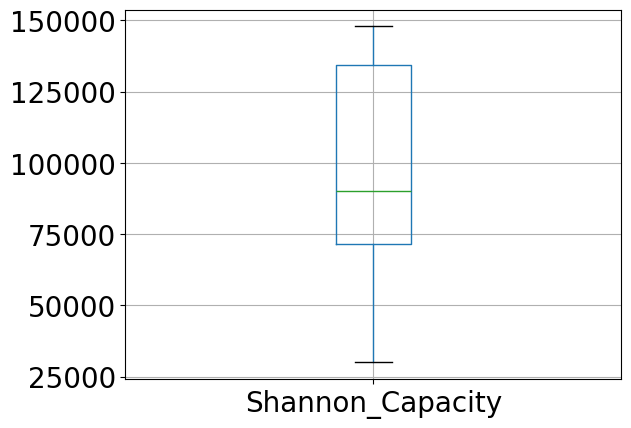

In [279]:
dfU.boxplot(column=['Shannon_Capacity'])
plt.show()

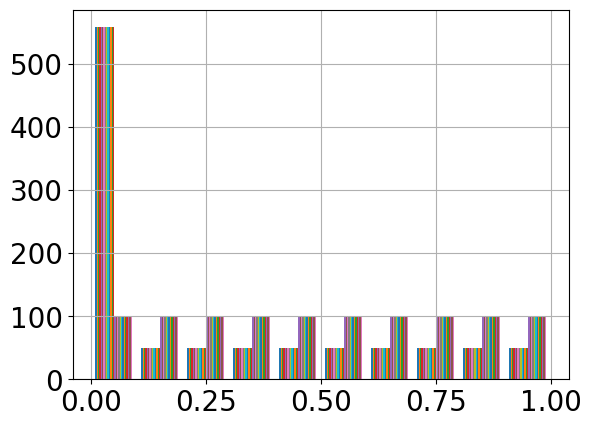

In [280]:
dfU['Latency_Cycle'].hist()
plt.show()

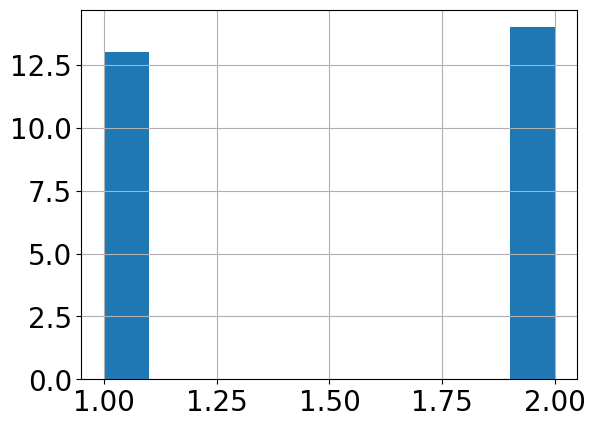

In [281]:
dfU['Cycle Length [ms]'].hist()
plt.show()

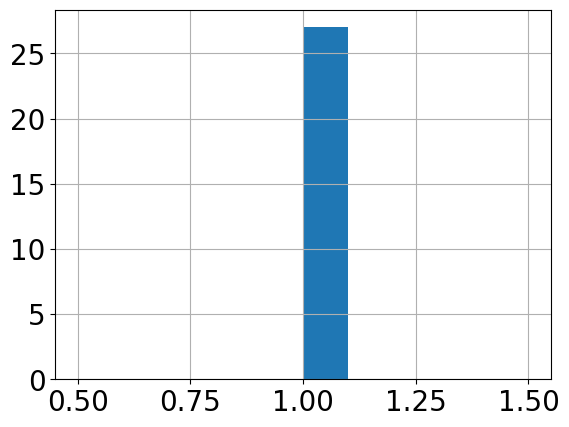

In [282]:
dfU['onTime [ms]'].hist()
plt.show()

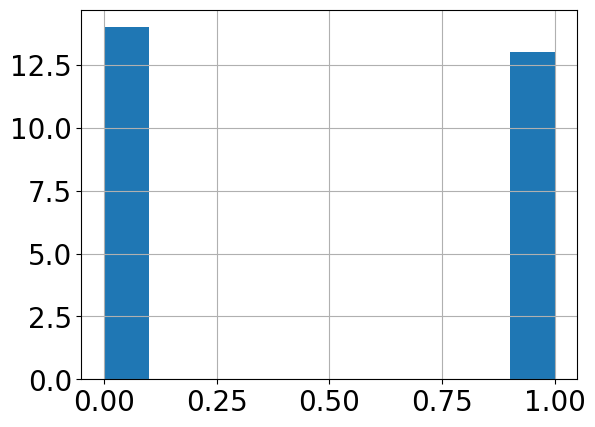

In [283]:
dfU['offset [ms]'].hist()
plt.show()

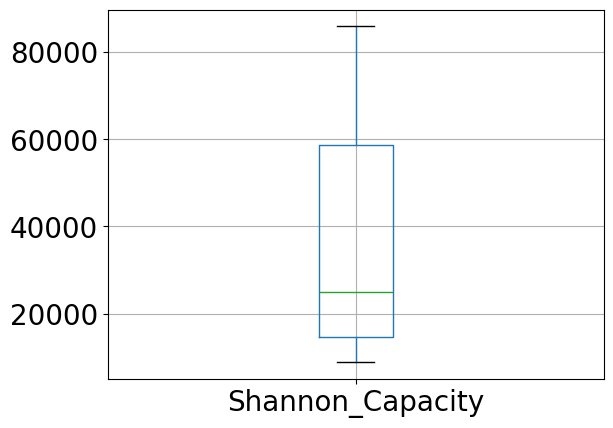

In [284]:
dfE.boxplot(column=['Shannon_Capacity'])
plt.show()

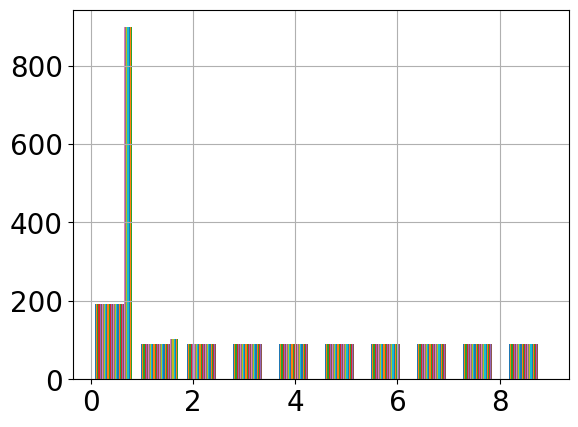

In [285]:
dfE['Latency_Cycle'].hist()
plt.show()

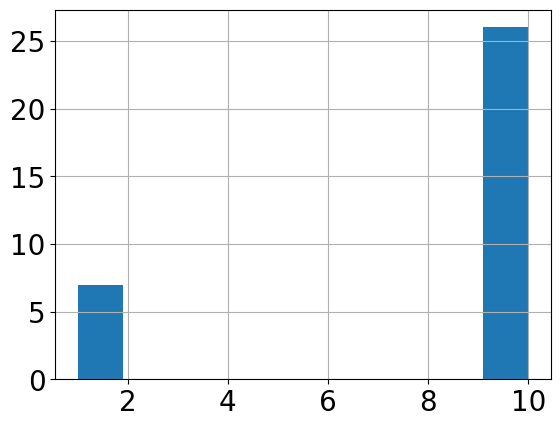

In [286]:
dfE['Cycle Length [ms]'].hist()
plt.show()

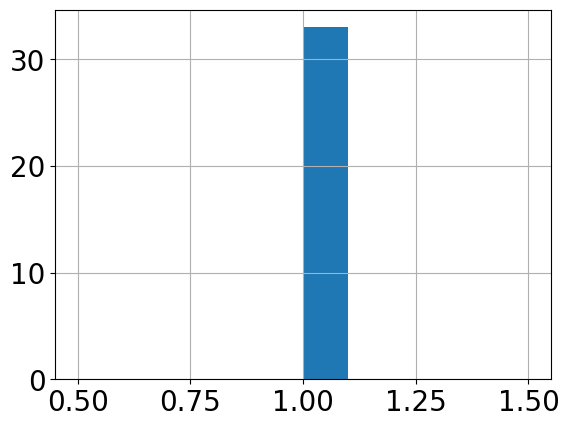

In [287]:
dfE['onTime [ms]'].hist()
plt.show()

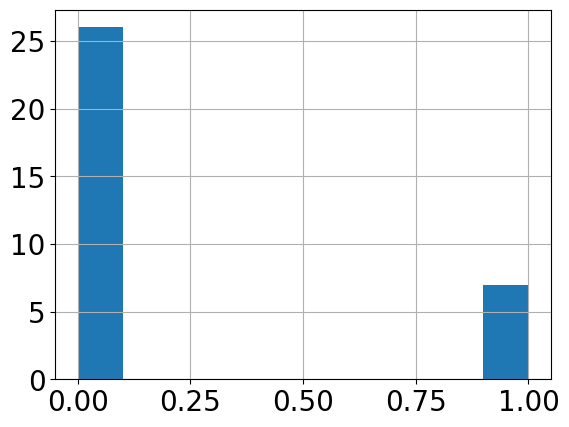

In [288]:
dfE['offset [ms]'].hist()
plt.show()

In [289]:
del dfU, dfE

#**Algorithm 2**

In [290]:
from mip import Model, xsum, MINIMIZE, BINARY
import numpy as np
import pandas as pd

# Inicializar os DataFrames de usuários
dfUEs = [inicializaUE(1, 9), inicializaUE(3, 7), inicializaUE(5, 5), inicializaUE(7, 3)]
tc = arrivalTimePoisson()
for df in dfUEs:
    df = df.sort_values(by=['Shannon_Capacity'], ascending=[False])
    transmissionTime(df, tc)

# Definir valores possíveis para as variáveis
valores_x = [2, 3, 4, 5, 6, 7, 8, 10, 14, 16, 20, 30, 32, 35, 40, 64, 80, 128, 160, 256, 320, 512, 640]
valores_y = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 800, 1000, 1200, 1600]
valores_z = [10, 20, 32, 40, 60, 64, 70, 80, 128, 160, 256, 320, 512, 640, 1024, 1280, 2048, 2560, 5120, 10240, 20480]
valores_w = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 800]
valores_h = [0, 10, 20, 32, 40, 60, 64, 70, 80, 128, 160, 256, 320, 512, 640, 1024, 1280, 2048, 2560, 5120, 10240]

# Função para calcular a latência total para usuários URLLC
def totalLatency(df, x, y):
    latencias = xsum((x[i] - y[i]) for i in range(len(x)))  # Alteração aqui para x - y
    return latencias

# Função para otimizar URLLC e eMBB com prioridade para capacidade de Shannon
def optimize_for_all_users(df):
    # Ordenar os usuários por Capacidade de Shannon e proximidade do estouro de latência
    #df['Latencia_Remaining'] = df['Max_Latency'] - df['Current_Latency']
    

    # Criar o modelo com objetivo de minimizar
    model = Model(sense=MINIMIZE)

    # Obter os índices dos usuários URLLC e eMBB após ordenação
    urllc_indices = df.query("Usuário == 'URLLC'").index
    embb_indices = df.query("Usuário == 'eMBB'").index

    # Criar variáveis binárias para escolher exatamente um valor de x e y para cada usuário URLLC
    bin_x = [[model.add_var(var_type=BINARY) for _ in range(len(valores_x))] for _ in urllc_indices]
    bin_y = [[model.add_var(var_type=BINARY) for _ in range(len(valores_y))] for _ in urllc_indices]

    # Criar variáveis binárias para escolher exatamente um valor de z, w e h para cada usuário eMBB
    bin_z = [[model.add_var(var_type=BINARY) for _ in range(len(valores_z))] for _ in embb_indices]
    bin_w = [[model.add_var(var_type=BINARY) for _ in range(len(valores_w))] for _ in embb_indices]
    bin_h = [[model.add_var(var_type=BINARY) for _ in range(len(valores_h))] for _ in embb_indices]

    # Garantir que apenas um valor seja selecionado para cada variável de cada usuário
    for i in range(len(bin_x)):
        model += xsum(bin_x[i]) == 1  # Apenas um valor de x por usuário URLLC
        model += xsum(bin_y[i]) == 1  # Apenas um valor de y por usuário URLLC
    for i in range(len(bin_z)):
        model += xsum(bin_z[i]) == 1  # Apenas um valor de z por usuário eMBB
        model += xsum(bin_w[i]) == 1  # Apenas um valor de w por usuário eMBB
        model += xsum(bin_h[i]) == 1  # Apenas um valor de h por usuário eMBB

    # Definir as variáveis x, y, z, w e h como os valores selecionados diretamente dos vetores
    x = [xsum(bin_x[i][j] * valores_x[j] for j in range(len(bin_x[i]))) for i in range(len(bin_x))]
    y = [xsum(bin_y[i][j] * valores_y[j] for j in range(len(bin_y[i]))) for i in range(len(bin_y))]
    z = [xsum(bin_z[i][j] * valores_z[j] for j in range(len(bin_z[i]))) for i in range(len(bin_z))]
    w = [xsum(bin_w[i][j] * valores_w[j] for j in range(len(bin_w[i]))) for i in range(len(bin_w))]
    h = [xsum(bin_h[i][j] * valores_h[j] for j in range(len(bin_h[i]))) for i in range(len(bin_h))]

    # Adicionar restrições
    for i in range(len(urllc_indices)):
        model += y[i] + 0.5 * y[i] <= x[i]  # Restrição y + 0.5 * y <= x

    for i in range(len(embb_indices)):
        model += w[i] + h[i] <= z[i]  # Restrição w + h <= z

    # Penalizar os usuários URLLC e eMBB de forma diferente para induzir variações
    total_power = xsum(1000 * x[i] + 70 * y[i] for i in range(len(x))) + \
                  xsum(1000 * z[i] + 30 * w[i] + 20 * h[i] for i in range(len(z)))

    # Definir a função objetivo no modelo
    model.objective = total_power

    # Criar variáveis binárias auxiliares para garantir variações
    bin_x_diff = [model.add_var(var_type=BINARY) for _ in range(1, len(x))]
    bin_y_diff = [model.add_var(var_type=BINARY) for _ in range(1, len(y))]
    bin_z_diff = [model.add_var(var_type=BINARY) for _ in range(1, len(z))]
    bin_w_diff = [model.add_var(var_type=BINARY) for _ in range(1, len(w))]

    # Restrições de variação relaxada para 80% dos usuários
    M = 1000  # Constante suficientemente grande para a restrição
    for i in range(1, len(x)):
        model += x[i] - x[i-1] >= -M * bin_x_diff[i-1]
        model += y[i] - y[i-1] >= -M * bin_y_diff[i-1]

    for i in range(1, len(z)):
        model += z[i] - z[i-1] >= -M * bin_z_diff[i-1]
        model += w[i] - w[i-1] >= -M * bin_w_diff[i-1]

    # Exigir que pelo menos 80% dos usuários apresentem variação
    model += xsum(bin_x_diff) >= len(urllc_indices) * 0.8
    model += xsum(bin_y_diff) >= len(urllc_indices) * 0.8
    model += xsum(bin_z_diff) >= len(embb_indices) * 0.8
    model += xsum(bin_w_diff) >= len(embb_indices) * 0.8

    # Restrições de latência para URLLC: a latência total deve ser menor que 15 ms
    model += totalLatency(df.query("Usuário == 'URLLC'"), x, y) <= 5  # Latência menor que 15 ms

    # Resolver o modelo
    model.optimize()
 # Verificar se uma solução foi encontrada
    if model.num_solutions:
        print(f"Solução encontrada para o DataFrame.")
        # Atualizar o DataFrame com os resultados individuais
        df.loc[urllc_indices, 'Cycle Length [ms]'] = [int(x[i].x) for i in range(len(x))]
        df.loc[urllc_indices, 'onTime [ms]'] = [int(y[i].x) for i in range(len(y))]
        df.loc[urllc_indices, 'offset [ms]'] = [int(0.5 * y[i].x) for i in range(len(y))]
        df.loc[embb_indices, 'Cycle Length [ms]'] = [int(z[i].x) for i in range(len(z))]
        df.loc[embb_indices, 'onTime [ms]'] = [int(w[i].x) for i in range(len(w))]
        df.loc[embb_indices, 'offset [ms]'] = [int(h[i].x) for i in range(len(h))]
    else:
        print(f"Nenhuma solução encontrada para o DataFrame.")

# Otimizar para todos os DataFrames
for df in dfUEs:
    optimize_for_all_users(df)

# Calcular métricas adicionais para cada DataFrame
for df in dfUEs:
    latencyCycle(tc, df)
    DCI(df)
    transmissionTime(df, tc)
    totalLatency1(df)
    power(df)

# Concatenar os resultados
dfU = pd.concat([df.query("Usuário == 'URLLC'") for df in dfUEs])
dfE = pd.concat([df.query("Usuário == 'eMBB'") for df in dfUEs])

# Liberar memória
del dfUEs

Solução encontrada para o DataFrame.
Nenhuma solução encontrada para o DataFrame.
Solução encontrada para o DataFrame.
Nenhuma solução encontrada para o DataFrame.


C:\Users\Joao_Pedro\AppData\Local\Temp\ipykernel_18256\2226380743.py:29: RuntimeWarning: divide by zero encountered in scalar remainder
  if group >= qtd_group and group % qtd_group == 0:
C:\Users\Joao_Pedro\AppData\Local\Temp\ipykernel_18256\2226380743.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['DCI_time'] = aux1.tolist()
C:\Users\Joao_Pedro\AppData\Local\Temp\ipykernel_18256\2226380743.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['DCI_time'] = aux2.tolist()
C:\Users\Joao_Pedro\Ap

In [291]:
powerU2 = np.array(dfU['Power'])
powerE2 = np.array(dfE['Power'])

sortPU_2 = np.sort(powerU2)
pPU_2 = 1.0 * np.arange(len(powerU2)) / float(len(powerU2) - 1)

sortPE_2 = np.sort(powerE2)
pPE_2 = 1.0 * np.arange(len(powerE2)) / float(len(powerE2) - 1)

In [292]:
capacityU = np.array(dfU['Shannon_Capacity'])
capacityE = np.array(dfE['Shannon_Capacity'])

sortCaU_2 = np.sort(capacityU)
pCaU_2 = 1.0 * np.arange(len(capacityU)) / float(len(capacityU) - 1)

sortCaE_2 = np.sort(capacityE)
pCaE_2 = 1.0 * np.arange(len(capacityE)) / float(len(capacityE) - 1)

In [293]:
latencyU_2 = np.array(list(dfU['Total_Latency'])).flatten()
latencyE_2 = np.array(list(dfE['Total_Latency'])).flatten()

sortlU_2 = np.sort(latencyU_2)
plU_2 = 1.0 * np.arange(len(latencyU_2)) / float(len(latencyU_2) - 1)

sortlE_2 = np.sort(latencyE_2)
plE_2 = 1.0 * np.arange(len(latencyE_2)) / float(len(latencyE_2) - 1)

In [294]:
dciU_2 = np.array(list(dfU['DCI_time'])).flatten()
dciE_2 = np.array(list(dfE['DCI_time'])).flatten()

sortdciU_2 = np.sort(dciU_2)
pdciU_2 = 1.0 * np.arange(len(dciU_2)) / float(len(dciU_2) - 1)

sortdciE_2 = np.sort(dciE_2)
pdciE_2 = 1.0 * np.arange(len(dciE_2)) / float(len(dciE_2) - 1)

In [295]:
transmitU_2 = np.array(list(dfU['Transmission_time'])).flatten()
transmitE_2 = np.array(list(dfE['Transmission_time'])).flatten()

sorttransmitU_2 = np.sort(transmitU_2)
ptransmitU_2 = 1.0 * np.arange(len(transmitU_2)) / float(len(transmitU_2) - 1)

sorttransmitE_2 = np.sort(transmitE_2)
ptransmitE_2 = 1.0 * np.arange(len(transmitE_2)) / float(len(transmitE_2) - 1)

In [296]:
cycleLaU_2 = np.array(list(dfU['Latency_Cycle'])).flatten()
cycleLaE_2 = np.array(list(dfE['Latency_Cycle'])).flatten()

sortcycleLaU_2 = np.sort(cycleLaU_2)
pcycleLaU_2 = 1.0 * np.arange(len(cycleLaU_2)) / float(len(cycleLaU_2) - 1)

sortcycleLaE_2 = np.sort(cycleLaE_2)
pcycleLaE_2 = 1.0 * np.arange(len(cycleLaE_2)) / float(len(cycleLaE_2) - 1)

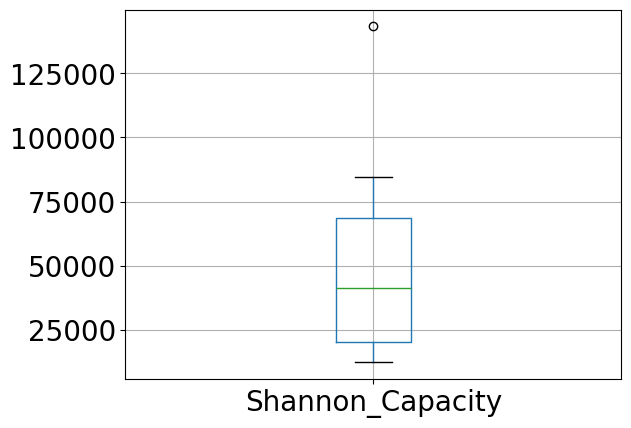

In [297]:
dfU.boxplot(column=['Shannon_Capacity'])
plt.show()

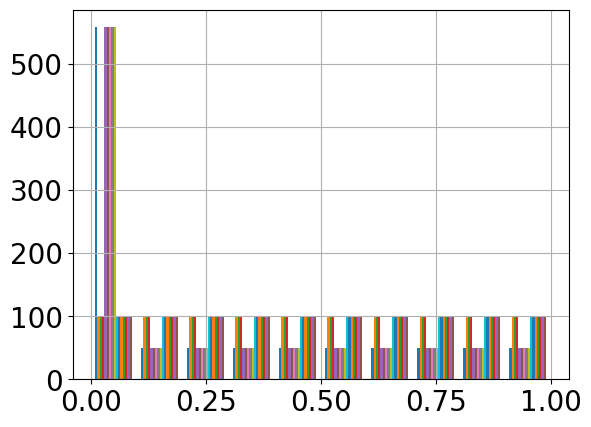

In [298]:
dfU['Latency_Cycle'].hist()
plt.show()

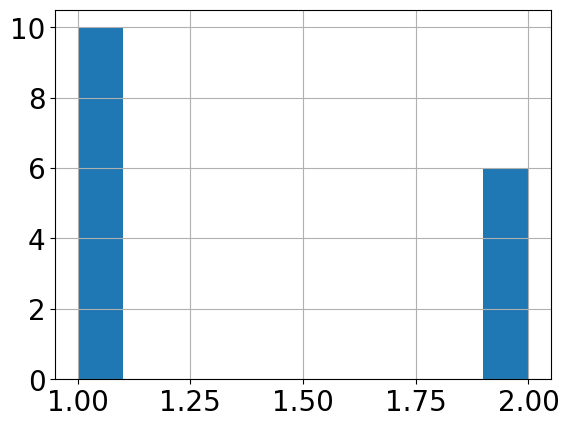

In [299]:
dfU['Cycle Length [ms]'].hist()
plt.show()

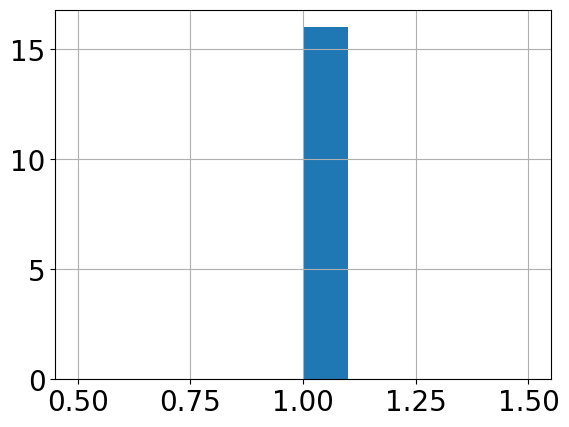

In [300]:
dfU['onTime [ms]'].hist()
plt.show()

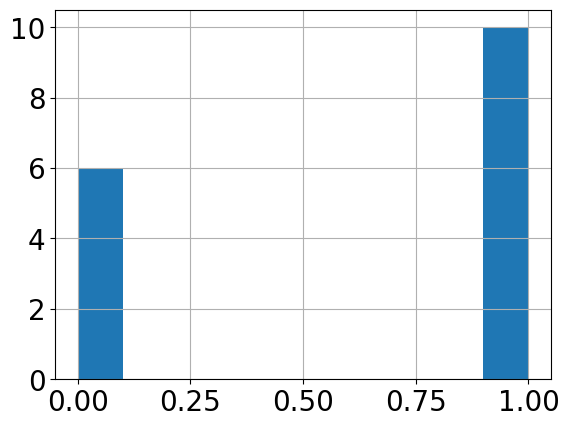

In [301]:
dfU['offset [ms]'].hist()
plt.show()

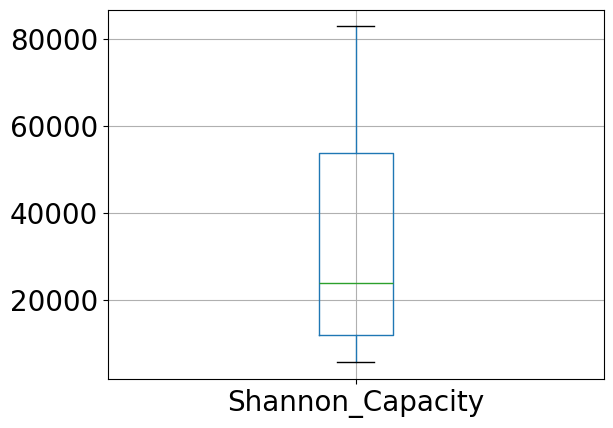

In [302]:
dfE.boxplot(column=['Shannon_Capacity'])
plt.show()

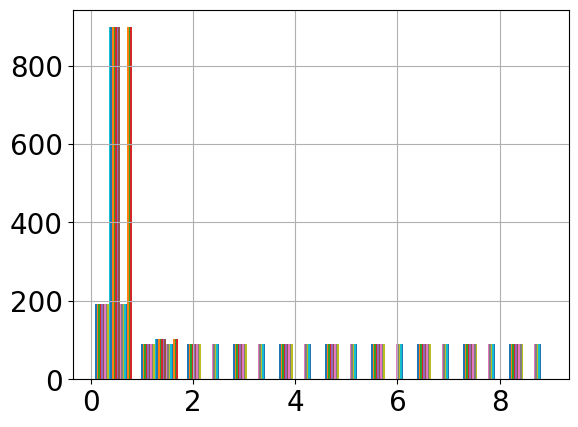

In [303]:
dfE['Latency_Cycle'].hist()
plt.show()

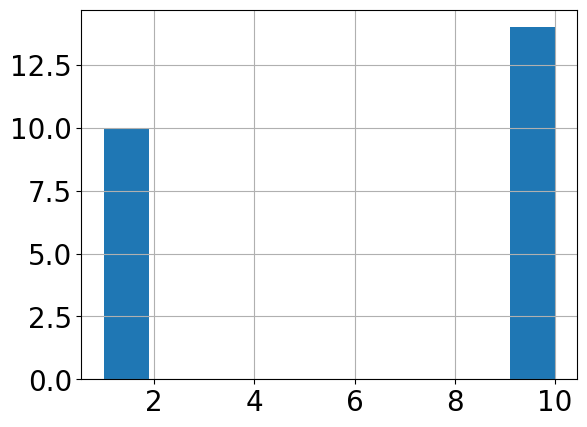

In [304]:
dfE['Cycle Length [ms]'].hist()
plt.show()

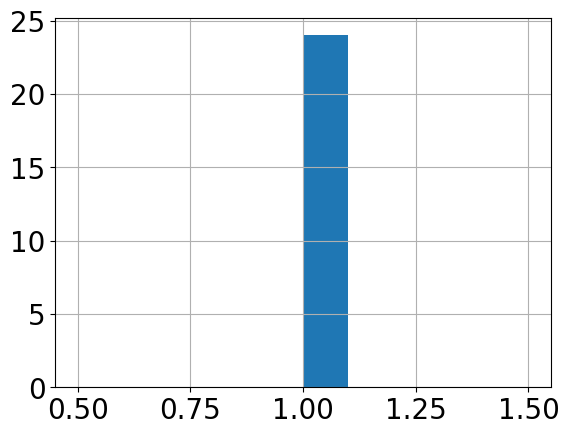

In [305]:
dfE['onTime [ms]'].hist()
plt.show()

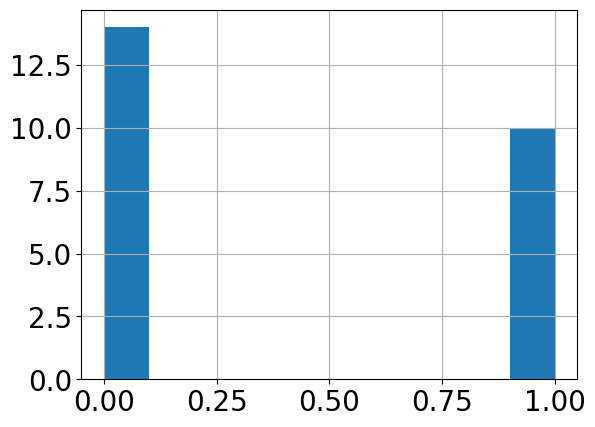

In [306]:
dfE['offset [ms]'].hist()
plt.show()

In [307]:
del dfU, dfE

#**CDF`s Plot**

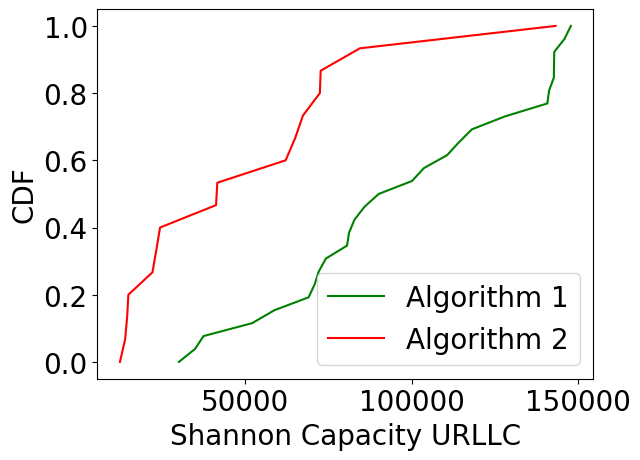

In [308]:
plt.plot(sortCaU_1, pCaU_1, "-g", label="Algorithm 1")
plt.plot(sortCaU_2, pCaU_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Shannon Capacity URLLC', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.show()

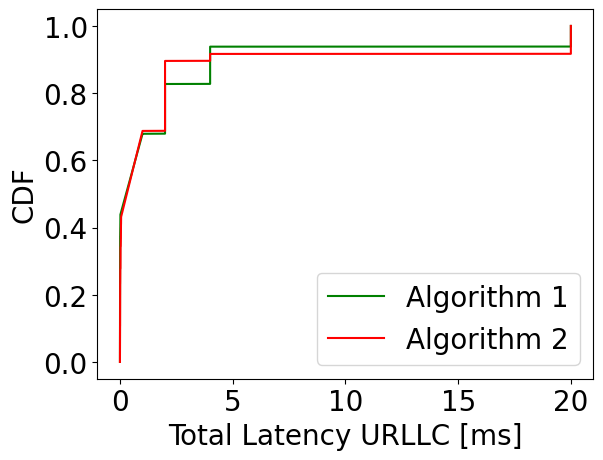

In [309]:
plt.plot(sortlU_1, plU_1, "-g", label="Algorithm 1")
plt.plot(sortlU_2, plU_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Total Latency URLLC [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.show()

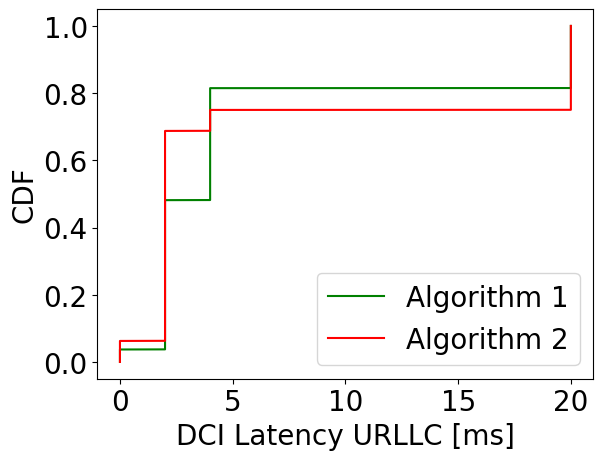

In [310]:
plt.plot(sortdciU_1, pdciU_1, "-g", label="Algorithm 1")
plt.plot(sortdciU_2, pdciU_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('DCI Latency URLLC [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.show()

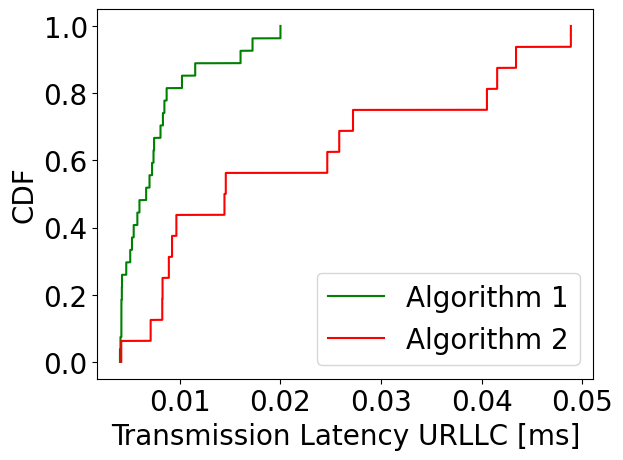

In [311]:
plt.plot(sorttransmitU_1, ptransmitU_1, "-g", label="Algorithm 1")
plt.plot(sorttransmitU_2, ptransmitU_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Transmission Latency URLLC [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.show()

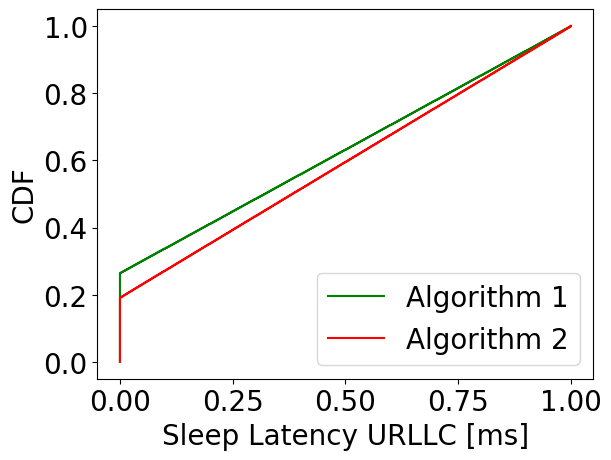

In [312]:
plt.plot(sortcycleLaU_1, pcycleLaU_1, "-g", label="Algorithm 1")
plt.plot(sortcycleLaU_2, pcycleLaU_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Sleep Latency URLLC [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.show()

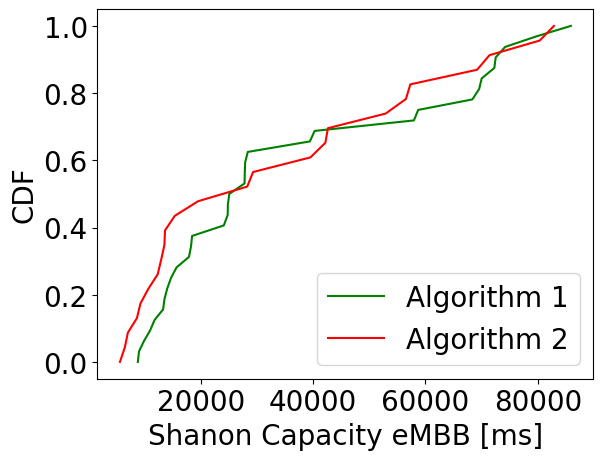

In [313]:
plt.plot(sortCaE_1, pCaE_1, "-g", label="Algorithm 1")
plt.plot(sortCaE_2, pCaE_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Shanon Capacity eMBB [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.show()

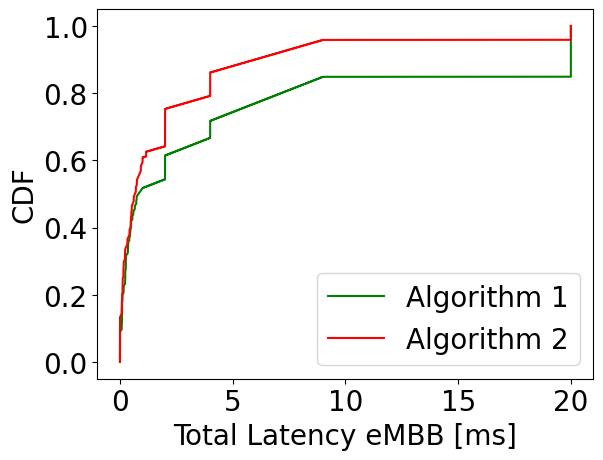

In [314]:
plt.plot(sortlE_1, plE_1, "-g", label="Algorithm 1")
plt.plot(sortlE_2, plE_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Total Latency eMBB [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.show()

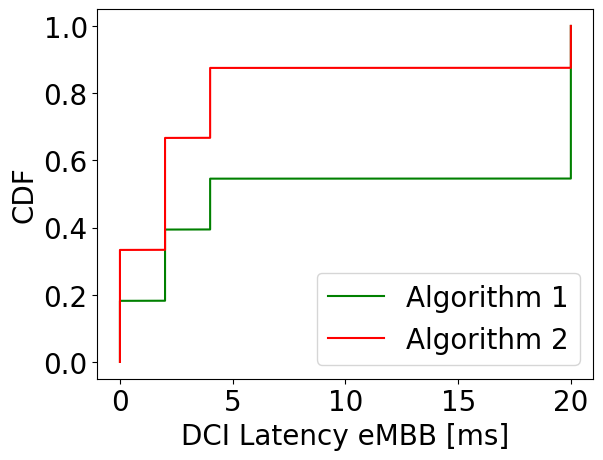

In [315]:
plt.plot(sortdciE_1, pdciE_1, "-g", label="Algorithm 1")
plt.plot(sortdciE_2, pdciE_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('DCI Latency eMBB [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.show()

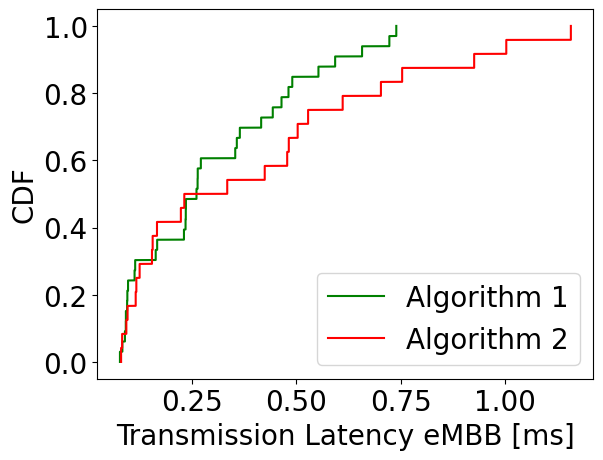

In [316]:
plt.plot(sorttransmitE_1, ptransmitE_1, "-g", label="Algorithm 1")
plt.plot(sorttransmitE_2, ptransmitE_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Transmission Latency eMBB [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.show()

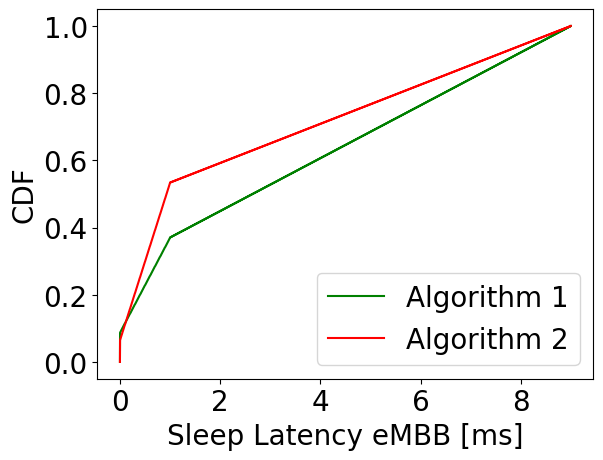

In [317]:
plt.plot(sortcycleLaE_1, pcycleLaE_1, "-g", label="Algorithm 1")
plt.plot(sortcycleLaE_2, pcycleLaE_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Sleep Latency eMBB [ms]', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.show()

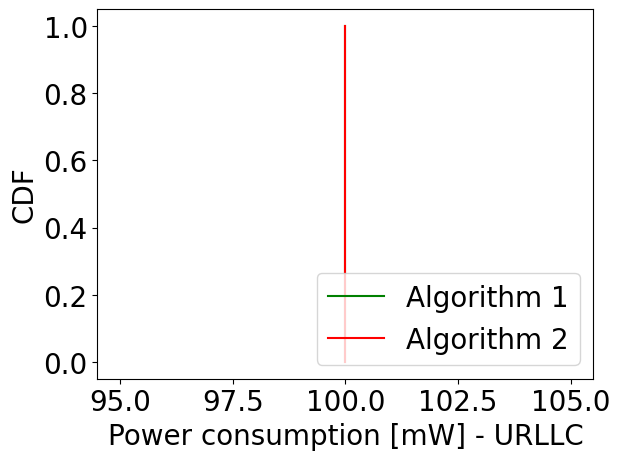

In [318]:
plt.plot(sortPU_1, pPU_1, "-g", label="Algorithm 1")
plt.plot(sortPU_2, pPU_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Power consumption [mW] - URLLC', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.show()

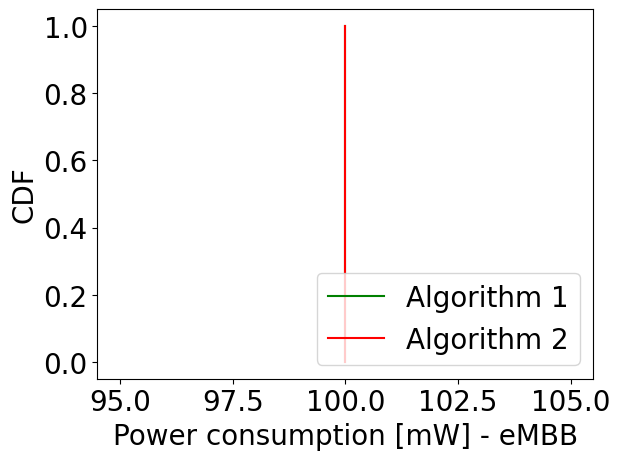

In [319]:
plt.plot(sortPE_1, pPE_1, "-g", label="Algorithm 1")
plt.plot(sortPE_2, pPE_2, "-r", label="Algorithm 2")
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Power consumption [mW] - eMBB', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.show()